<a href="https://colab.research.google.com/github/johanjan/swallow/blob/master/notebook_Bolus_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *; from ufl import*
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics:1:2019.2.0.0~ppa1~eoan1
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    #!conda config --add channels conda-forge
    #!conda install fenics

from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

import pylab as pyl #

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [88.1 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InReleas

geom:  cyl  nu:  0.0e+00
ref:  1.0
prefix:  cyl_0.0e+00
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving pressure eq
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


AttributeError: ignored

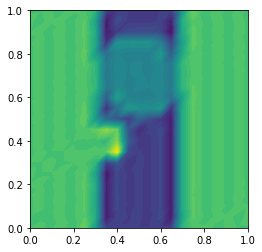

In [2]:
"""This demo program solves the incompressible Navier-Stokes equations
with a goal-oriented, least-squares stabilized method.
"""

# Copyright (C) 2013 Johan Jansson (jjan@kth.se)
# (2020) Måns Andersson (mansande@kth.se)

# This file is part of FEniCS
#
# FEniCS is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.


# Possible fixes for unkonw errors
# 1. Do a factory reset on the notebook (Runtime --> Factory Reset)
# 2. Change the version of the binary 


from dolfin import *
import math
import time
import os
import sys
import os


#geom = sys.argv[1]
#nnu = float(sys.argv[2])
nnu = 0.0
mu = 2.e1

Y_MAX = 0.41
X_MAX = 2.2

soff = 3


rhoMin = 0.001
#rhoMin = 0.001
#rhoMin = 0.5
#rhoMax = 1.0
rhoMax = 1.0

# SubDomains for defining boundary conditions

geps = 1.0e-8
wbeps = 1.0e-1

dd = 1.0

class InnerBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] <= 1.0 - geps and x[0] >= 0. + geps and \
                                   x[1] <= 1. - geps and x[1] >= 0. + geps)

class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and \
            ((x[0] > 0.3) and (x[0] < 0.7) and \
            ((x[1] > 1. - geps ) or (x[1] < 0. + geps)))

class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):

        ob = OutflowBoundary();
        
        return on_boundary and (not ob.inside(x, on_boundary))

class WallBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and( x[1] > Y_MAX - DOLFIN_EPS or \
                                    x[1] < DOLFIN_EPS)

class InflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and(x[0] <  DOLFIN_EPS )
   
            

# Coefficients for defining boundary conditions
class Inflow(UserExpression):
    def eval(self,values, x):
        values[0] = 4*1.0*(x[1]*(Y_MAX-x[1]))/(Y_MAX*Y_MAX)
        values[1] = 0
    def value_shape(self):
        return (2,)

class Force(UserExpression):
    def eval(self,values, x):
        values[0] = 0
        if(x[0] <= -1.5*dd):
            values[1] = 0
        else:
            values[1] = 0

    def value_shape(self):
        return (2,)

class PsiMarker(UserExpression):
    def eval(self, values, x):
        ib = InnerBoundary()

        if(ib.inside(x, True)):
            values[0] = 1.0
        else:
            values[0] = 0.0
    
#    def value_shape(self):
#        return (1,)

# Known coefficients
u0_0 = Constant((0.0, 0.0))
g = Constant((0.0, 1.0*-9.8))
ft = Force()
u0_0p = Constant(0.0)
u0_0rho = Constant(rhoMin)
psimarker = PsiMarker()

# Use compiler optimizations
parameters["form_compiler"]["cpp_optimize"] = True

# Allow approximating values for points that may be generated outside
# of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True


###### Modify for exercise below ######

geom = "cyl"

ref_dict = {}
ref_dict[("square", "%1.1e" % 1e-2)] = 2.42051578e+00
ref_dict[("square", "%1.1e" % 5e-3)] = 2.48093509e+00
ref_dict[("cyl", "%1.1e" % 1e-2)] = 2.40462720e+00
ref_dict[("cyl", "%1.1e" % 5e-3)] = 2.46237040e+00
ref_dict[("cyl", "%1.1e" % 5e-4)] = 2.46237040e+00
ref_dict[("square", "%1.1e" % 5e-4)] = 2.46237040e+00

ref = 1.0

print( "geom: ", geom, " nu: ", "%1.1e" % nnu)
print( "ref: ", ref)

adapt_ratio = 0.1

def M(mesh, u, rho, p):

    def epsilon(z):
        return 0.5*(grad(z) + grad(z).T)

    n = FacetNormal(mesh)

    I = Identity(2)
    sigma = p*I - nnu*epsilon(u)
    theta = Constant((1.0, 0.0))

    g = Expression(("200.0*exp(-200.0*(pow(x[0] - 0.5, 2) + pow(x[1] - 0.3, 2)))", "0.0"), degree = 2)                              

    M1 = psimarker*p*n[0]*ds # Drag (only pressure)
    M2 = psimarker*p*n[1]*ds # Lift (only pressure)
    M3 = inner(g, u)*dx # Mean of the velocity in a region
    M4 = psimarker*dot(dot(sigma, n), theta)*ds # Drag (full stress)
    M5 = u[0]*dx # Mean of the x-velocity in the whole domain

    return M1
    #return M5

    #strong residual for cG(1)cG(1)                                                                 
def strong_residual(w, w2, ww):
    (u, rho) = (as_vector((w[0], w[1])), w[2])
    (U, Rho) = (as_vector((w2[0], w2[1])), w2[2])
    (uu, rhorho) = (as_vector((ww[0], ww[1])), ww[2])

    R1 = Rho*grad(U)*u - rho*g
    R2 = inner(u, grad(Rho))
    R3 = div(u)

    return R1, R2, R3


# The weak residual with w the solution and wt the test function
def r(W, w, ww, wt, w0, wprev, t, k, wb, p, p0, ptr, q, RSc, ei_mode=True, stab0=1.0, stab1=1.0, stab2=1.0):

    #dx = Measure('dx', domain=W.mesh())

    (u, rho, p) = (as_vector((w[0], w[1])), w[2], p)
    (uu, rhorho, p) = (as_vector((ww[0], ww[1])), ww[2], p)
    (v, nu, q) = (as_vector((wt[0], wt[1])), wt[2], q)
    (u0, rho0, p0) = (as_vector((w0[0], w0[1])), w0[2], p0)
    (up, rhop, pp) = (as_vector((wprev[0], wprev[1])), wprev[2], p)

    sigma = as_matrix([[w[soff+a+b] for b in range(0, 2)] for a in range(0, 2)])
    sigma0 = as_matrix([[w0[soff+a+b] for b in range(0, 2)] for a in range(0, 2)])
    sigmasigma = as_matrix([[ww[soff+a+b] for b in range(0, 2)] for a in range(0, 2)])
    y = as_matrix([[wt[soff+a+b] for b in range(0, 2)] for a in range(0, 2)])

    rhom = abs(rho)
    rhorhom = abs(rhorho)
    rhom0 = abs(rho0)

    #delta = Delta(W.mesh())

    h = CellDiameter(W.mesh())
    delta = h
    n = FacetNormal(W.mesh())

    cv = CellVolume(W.mesh())
    icv = 1./cv

    Z = FunctionSpace(W.mesh(), "DG", 0)
    z = TestFunction(Z)

    if(not ei_mode):
        z = 1.0

    if(t <= 0.1):
        f = g + ft
    else:
        f = g

    # Define variational forms
    # Multiply by z to be able to extract error indicators for each cell

    def epsilon(z):
        return 0.5*(grad(z) + grad(z).T)

    I = Identity(2)
    one = as_vector((1.0, 1.0))

    stab3 = 1e-12
    if(t <= k):
        stab3 = 1e-6

    F_t = z*1.0 / k * rhom*inner(uu - u0, v)*dx + z*1.0 / k * inner(rhorho - rho0, nu)*dx + \
        z*1.0 / k * inner(sigmasigma - sigma0, y)*dx + \
        stab3*inner(grad(w), grad(wt))*dx

    wb2 = 1. - wb

    theta = abs((rhom - rhoMin) / (rhoMax - rhoMin))
    theta2 = abs((rhom - rhoMax) / (rhoMax - rhoMin))
    #theta = conditional(ge(rhom, rhoMax / 4.), 1., 0.)

    mumu = conditional(gt(rho, 0.75), mu, mu/4.)

    F_G = z*inner(u, grad(rho))*nu*dx
    F_G += z*(inner(rho*grad(u)*u + grad(p),v) - theta*inner(sigma, grad(v)) + nnu*inner(grad(u),grad(v)) - rho*dot(f,v))*dx
    F_G += z*(inner(dot(u, grad(sigma)) + \
                    theta*(2*rho*mumu*epsilon(u) + grad(u)*sigma + sigma*grad(u).T), y))*dx

    def epsilon(z):
        return 0.5*(grad(z) + grad(z).T)
    

    d = stab0*h**(3./2.) #stabilization parameter
    dp = h**(3./2.) #stabilization parameter
    dd1 = h**(2.) + h**(3./2.)*wb
    dd2 = h**(2.)
    dd3 = h**(3./2.)

    #R1, R2, R3 = strong_residual(w, w, ww)
    #Rv1, Rv2, Rv3 = strong_residual(wt, w, wt)

    R = [rho*grad(u)*u - rho*f, inner(u, grad(rho)), div(u), dot(u, grad(sigma))]
    R_v = [rho*grad(v)*u, inner(v, grad(rho)), div(v), 0]
    R_nu = [nu*grad(u)*u, inner(u, grad(nu)), 0, 0]
    R_q = [grad(q), 0, 0, 0]
    R_y = [0, 0, 0, dot(u, grad(y))]

    LS_u = d*(inner(R[0], R_v[0]) + inner(R[1], R_v[1]) + inner(R[2], R_v[2]))
    LS_rho = d*(inner(R[0], R_nu[0]) + inner(R[1], R_nu[1]) + inner(R[2], R_nu[2]))
    LS_p = d*(inner(R[0] + grad(p), R_q[0]) + inner(R[1], R_q[1]) + inner(R[2], R_q[2]))
    LS_sigma = d*(inner(R[3], R_y[3]))

    #F_stab = z*(d*inner(R1 - rho*f, Rv1) + d*(R2)*Rv2 + d*R3*Rv3)*dx
    #F_stab += z*(d*inner(dot(u, grad(sigma)), dot(u, grad(y))))*dx
    F_stab = z*LS_u*dx
    F_stab += z*LS_rho*dx
    F_stab += z*LS_sigma*dx


    Cav = (abs(u[0]) + abs(u[1]))

    F_stab += z*Cav*(stab1*dd2*RSc + stab2*dd3)*inner(grad(u),grad(v))*dx
    F_stab += z*Cav*(stab1*dd2*RSc + stab2*dd3)*inner(grad(rho),grad(nu))*dx
    F_stab += z*(Cav*10*stab1*dd2*RSc + stab2*dd3)*inner(grad(sigma),grad(y))*dx

    F = F_t + F_G + F_stab

    alpha = 1.0

    FP_G = z*((div(u)*q))*dx # continuity equation           
    FP_stab = z*(d*inner(1.0 / k * rho*(uu - u0) + rho*grad(u)*u + grad(p) - rho*f, grad(q)))*dx
    FP_schur = z*(alpha*(inner(grad(p) - grad(p0), grad(q))))*dx

    FP = FP_G + FP_stab + FP_schur

    aP = z*(dp*inner(grad(ptr), grad(q)) + alpha*(inner(grad(ptr), grad(q))))*dx
    LP = z*(-div(u)*q - dp*inner(rho*grad(u)*u - rho*f, grad(q)) + alpha*(inner(grad(p0), grad(q))))*dx

    Z = FunctionSpace(W.mesh(), "DG", 0)
    z = TestFunction(Z)

    Csc = icv

    FR = z*Csc*abs(1.0 / k * (rhorho - rho0) + inner(u, grad(rho)))*dx + \
         z*Csc*abs((1.0 / k * rho*(uu - u0) + grad(p) + R[0])[0])*dx + \
         z*Csc*abs((1.0 / k * rho*(uu - u0) + grad(p) + R[0])[1])*dx
    #FR = z*Csc*abs(1.0 / k * (rhorho - rho0) + inner(u, grad(rho)))*dx + \
    #     z*Csc*abs((1.0 / k * rho*(uu - u0) + R1 + grad(p))[0])*dx + \
    #     z*Csc*abs((1.0 / k * rho*(uu - u0) + R1 + grad(p))[1])*dx

    return (F, FR, FP, aP, LP)


###### Modify for exercise above ######



# Solve primal and dual equations and compute error indicators
def adaptive_solve(mesh, i):

    # Define function spaces
    """Z = FunctionSpace(mesh, "DG", 0)
    V = VectorFunctionSpace(mesh, "CG", 1)
    Q = FunctionSpace(mesh, "CG", 1)
    Y = TensorFunctionSpace(mesh, "CG", 1)
    W = MixedFunctionSpace([V, Q, Y])
    Wp = Q"""
    
    h = CellDiameter(mesh)

    # Define function spaces
    Z = FunctionSpace(mesh, "DG", 0)
    V = VectorFunctionSpace(mesh, "CG", 1)
    Q = FunctionSpace(mesh, "CG", 1)
    Wp = FunctionSpace(mesh, "CG", 1)
    
    VE = VectorElement("CG", mesh.ufl_cell(), 1)
    QE = FiniteElement("CG", mesh.ufl_cell(), 1)
    YE = TensorElement("CG", mesh.ufl_cell(), 1)
    
    W = FunctionSpace(mesh, MixedElement([VE,QE,YE]))

    # primal solver boundary conditions
    bc_0_0 = DirichletBC(W.sub(0), u0_0, NoslipBoundary())
    bc_0_1 = DirichletBC(W.sub(1), u0_0rho, OutflowBoundary())
    bc_0_2 = DirichletBC(Wp, u0_0p, OutflowBoundary())

    # Define unknown and test function(s)
    (v, nu, y) = TestFunctions(W)
    wt = TestFunction(W)
    q = TestFunction(Wp)
    ptr = TrialFunction(Wp)
    w = Function(W)
    w0 = Function(W)
    wprev = Function(W)
    p = Function(Wp)
    p0 = Function(Wp)
    phi = Function(W)
    phi0 = Function(W)
    
    # -- TEMP --
    phi_p = Function(W)
    psi_u = Function(W)
    psi_rho= Function(W)
    psi_p = Function(W)
    phi_u = Function(W)
    phi_rho  = Function(W)
    ei = Function(W)

    (u, rho, p) = (as_vector((w[0], w[1])), w[2], p)
    (phi_u0, phi_rho0) = (as_vector((phi0[0], phi0[1])), phi0[2])

    class InitialConditions(UserExpression):
        def eval(self,values,x):
            dd = 1.0

            #values[0] = 0.
            #values[1] = 0.

            #values[2] = \
            #    rhoMax * (x[1] - 1.0) / (-1.0 - 1.0) + rhoMin * (x[1] - -1.0) / (1.0 - -1.0)
            #values[2] = rhoMax / 2.0

            r1 = sqrt((x[1] - 0.7*dd)**2 + (x[0] - 0.5*dd)**2)
            r2 = sqrt((x[1] - 0.4*dd)**2 + (x[0] - 0.35*dd)**2)

            values[2] = rhoMin;

            if r1 <= 0.2:
                values[2] = rhoMax/2.

            if r2 <= 0.1:
                values[2] = rhoMax

            if x[0] <= 0.3 or x[0] >= 0.7:
                values[2] = rhoMax

            #if x[1] >= 0.5 and x[1] <= (0.5 + 0.05 / 2.) and x[0] >= 0.5 and x[0] <= 1.:
            #    values[2] = rhoMax
            #else:
            #    values[2] = rhoMin

            #if x[0] <= -1.5*dd and x[1] <= -0.2*dd and x[0] >= -3.0*dd and x[1] >= -1.0*dd:
            #    values[2] = rhoMax
            #if x[0] <= -1.0*dd and x[0] >= -2.0*dd and x[1] <= (0.2*cos(x[0]*(2*math.pi/2.0)) - 0.5):
            #    values[2] = rhoMax

        def value_shape(self):
            return (7,)


    #w0.vector()[:] = 0.0
    
    wi0 = InitialConditions()
    #w0 = project(w0,W)                                                                                                           
    ww0 = TrialFunction(W)
    vi = TestFunction(W)
    F = inner(ww0, vi)*dx + 1e-9*inner(grad(ww0), grad(vi))*dx
    Fh = inner(wi0, vi)*dx
    ww0 = Function(W)
    solve(F == Fh, ww0)


    VS = FunctionSpace(W.mesh(), 'CG', 1)

    bc0 = DirichletBC(VS, Constant(1.0), NoslipBoundary())

    h = CellDiameter(VS.mesh())
    wb = Function(VS)
    wbt = TestFunction(VS)

    F = wb*wbt*dx + h**(3./2.)*inner(grad(wb), grad(wbt))*dx
    solve(F == 0, wb, bc0, solver_parameters={"newton_solver": {"linear_solver": "iterative", "maximum_iterations": 30}})

    wf = File("wb.pvd")
    #wf << wb

    w0.assign(ww0)
    #w0 = wi0

    t = 0.0
    T = 0.01
    #k = 0.02*MPI.min(mesh.mpi_comm(), mesh.hmin())
    k = 0.02*mesh.hmin();
    
    n = FacetNormal(mesh)

    # Primal boundary conditions
    bcs = [bc_0_0, bc_0_1]
    bcsp = [bc_0_2]

    outfile_ut = File("u_%2.2d.pvd" % i)
    outfile_rhot = File("rho_%2.2d.pvd" % i)
    outfile_pt = File("p_%2.2d.pvd" % i)
    outfile_R = File("R_%2.2d.pvd" % i)
    outfile_sigma = File("sigma_%2.2d.pvd" % i)

    w_primal = []

    Ri = Function(Z)
    Ri.vector()[:] = 0.0

    wprev.assign(w)
    p0.assign(p)

    rtol = 0.02

    output = 0.0
    pi = 0
    while(t <= T):

        if False and t <= 2*k:
            stab0 = 0.02
            stab1 = 0.01
            stab2 = 0.0
        else:
            stab0 = 0.02
            stab1 = 0.01
            stab2 = 0.0

        #if t >= 20*k and k <= 0.005*mesh.hmin():
        #    k *= 1.1
            #k = 0.005*mesh.hmin();
            #k = 0.0005*mesh.hmin();
            


        # Solve the primal problem
        for it in range(0, 20):
            # The variational form
            (F, FR, FP, aP, LP) = r(W, 0.5*(w + w0), w, wt, w0, wprev, t, k, wb, p, p0, ptr, q, Ri, ei_mode=False, stab0=stab0, stab1=stab1, stab2=stab2)

            print( "Solving pressure eq" )
            #solve(FP == 0, p, bcsp, solver_parameters={"newton_solver": {"linear_solver": "iterative", "maximum_iterations": 30}})
            solve(aP == LP, p, bcsp, solver_parameters={"linear_solver": "iterative"})

            # The variational form
            (F, FR, FP, aP, LP) = r(W, 0.5*(w + w0), w, wt, w0, wprev, t, k, wb, p, p0, ptr, q, Ri, ei_mode=False, stab0=stab0, stab1=stab1, stab2=stab2)

            print( "Solving momentum eq")
            #solve(F == 0, w, bcs, solver_parameters={"newton_solver": {"linear_solver": "iterative", "maximum_iterations": 30}})
            solve(F == 0, w, bcs, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
            #Ri.vector()[:] = assemble(FR).array()
            assemble(FR, tensor=Ri.vector())

            wmag = w.vector().norm("linf")
            wprev.vector().axpy(-1.0, w.vector())
            wdiff = wprev.vector().norm("linf")
            wdiffrel = wdiff / wmag
            #if(MPI.rank(mesh.mpi_comm()) == 0):
            print( "wdiffrel: ", wdiffrel )

            wprev.assign(w)
            p0.assign(p);

            if wdiffrel <= rtol:
                #print "Fixed-point converged it:", it, "t:", t, "k:", k
                break
            
        #if(MPI.rank(mesh.mpi_comm()) == 0):
        print( "Fixed-point it:", it, "t:", t, "k:", k)
        #print "Fixed-point it:", it, "t:", t, "k:", k

        #solve(F == 0, w, bcs)
        #solve(FP == 0, p, bcsp)
        #Ri.vector()[:] = assemble(FR).array()

        (u, rho, p) = (as_vector((w[0], w[1])), w[2], p)
        (u0, rho0) = (as_vector((w0[0], w0[1])), w0[2])
        sigma = as_matrix([[w[soff+a+b] for b in range(0, 2)] for a in range(0, 2)])

        u_out = project(u, V)
        rho_out = project(rho, Q)
        p_out = project(p, Q)
        p0_out = project(p0, Q)
        sigma_out = project(abs(sqrt(inner(sigma, sigma))), Q)
        #ppmax = max(p_out.vector().array()[:])
        #pp0max = max(p0_out.vector().array()[:])
        #print "ppmax: ", ppmax
        #print "pp0max: ", pp0max
        print( "stab1: ", stab1)
        print( "stab2: ", stab2)
        print( "k: ", k)

        #(u_out, rho_out, p_out) = w.split()

        w0.assign(w);

        u_out.rename("u", "")
        rho_out.rename("rho", "")
        p_out.rename("p", "")
        sigma_out.rename("sigma", "")

        if pi % 10 == 0:
            outfile_ut << u_out
            outfile_rhot << rho_out
            outfile_pt << p_out
            outfile_R << Ri
            outfile_sigma << sigma_out

        plot(rho_out)
        #w_primal.append(w.copy())

        # Compute output
        if(t > 0.5*T):
            output += assemble(M(mesh, u, rho, p))

        t += k
        pi += 1

    # Compute output
    #output = assemble(M(mesh, u, p))

    return (u, rho, p, phi_u, phi_rho, phi_p, psi_u, psi_rho, psi_p, output, ei)

# Refine the mesh based on error indicators
def adaptive_refine(mesh, ei, adapt_ratio, adaptive):
    gamma = abs(ei.vector().array())

    # Mark cells for refinement
    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
    gamma_0 = sorted(gamma, reverse=True)[int(len(gamma)*adapt_ratio) - 1]
    for c in cells(mesh):
        cell_markers[c] = gamma[c.index()] > gamma_0

    # Refine mesh
    if adaptive:
        mesh = refine(mesh, cell_markers)
    else:
        mesh = refine(mesh)

    return mesh

import pylab as pyl

def solve_problem(adaptive=True):

    # Mesh
    mesh = UnitSquareMesh(20, 20)
    #mesh = Mesh()
    #if geom == "cyl":
    #    mesh = Mesh("mesh.xml")
    #elif geom == "square":
    #    mesh = Mesh("cube.xml")
    #mesh = Mesh("turek.xml")
    #mesh = Mesh("cylinder.xml")
    #mesh = refine(mesh)
    #mesh = refine(mesh)
    #mesh = refine(mesh)
    #mesh = refine(mesh)

    prefix = "%s_%1.1e" % (geom, nnu)
    print( "prefix: ", prefix)

    outfile_u = File("%s_u.pvd" % prefix)
    outfile_rho = File("%s_rho.pvd" % prefix)
    outfile_phi = File("%s_phi.pvd" % prefix)
    outfile_ei = File("%s_ei.pvd" % prefix)
    outfile_psi = File("%s_psi_p.pvd" % prefix)

    #maxiters = 35
    maxiters = 20

    results = []

    u0 = None

    # Adaptive loop
    for i in range(0, maxiters):

        # Solve primal and dual equations and compute error indicators
        (u, rho, p, phi_u, phi_rho, phi_p, psi_u, psi_rho, psi_p, output, ei) = adaptive_solve(mesh, i)

        # Compute error estimate and compare against reference value
        est = abs(sum(ei.vector().array()))
        err = abs(ref - output)
        result = (output, est, err, mesh.num_vertices())
        results.append(result)
        print( "output: %5.5f est: %5.5f err: %5.5f vertices: %d" % (output, est, err, mesh.num_vertices()))

        # Output solution and associated functions
        # meshfilename = "mesh_%2.2i.xml" % i
        # meshfile = File(meshfilename)
        # meshfile << mesh
        # outfile_u << u
        # outfile_rho << rho
        # outfile_phi << phi_u
        # outfile_ei << ei
        # outfile_psi << psi_p

        # Functionspace used for plotting
        Q = FunctionSpace(mesh, "CG", 1)

        # Plot
        if(True and i == 0):
            print( "foo")
            #p = plot(mesh, title="Initial mesh", size=((600, 300)))
            #p.write_png("mesh-initial.png")
            #time.sleep(1)
            #p = plot(project(sqrt(u[0]**2 + u[1]**2), Q), title="Magnitude of velocity on initial mesh",
            #         warpscalar=False, size=((400, 400)))
            #p.write_png("u-initial.png")

        elif(True and i == maxiters - 1):
            print( "foo")
            #p = plot(mesh, title="Finest mesh", size=((600, 300)))
            #p.write_png("mesh-finest.png")
            #time.sleep(1)
            #p = plot(project(sqrt(u[0]**2 + u[1]**2), Q), title="Magnitude of velocity on finest mesh",
            #         warpscalar=False, size=((400, 400)))
            #p.write_png("u-finest.png")
            #time.sleep(1)
            #p = plot(project(sqrt(phi_u[0]**2 + phi_u[1]**2), Q), title="Magnitude of dual velocity on finest mesh",
            #         warpscalar=False, interactive=True, size=((400, 400)))
            #p.write_png("phi_u-finest.png")

        # Refine the mesh
        mesh = adaptive_refine(mesh, ei, adapt_ratio, adaptive)

    # Compile the adaptivity results in a table
    for result in results:
        print( "output: %8.8e est: %8.8e err: %8.8e verticess: %d" % result)

    a_vertices = pyl.zeros(len(results))
    a_est = pyl.zeros(len(results))
    a_err = pyl.zeros(len(results))

    for i in range(0, len(results)):
        a_vertices[i] = results[i][3]
        a_est[i] = results[i][1]
        a_err[i] = results[i][2]

    a_all = pyl.array([a_vertices, a_est, a_err])

    datafile = "%s_nu_%1.1e.dat" % (geom, nu)

    pyl.savetxt(datafile, a_all)

# Solve the problem
solve_problem(adaptive=True)
#solve_problem(adaptive=False)
